<a href="https://colab.research.google.com/github/bh8648/DL/blob/main/DL221102.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

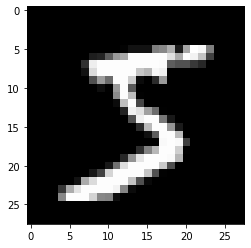

torch.Size([60000, 784]) torch.Size([60000])
input_size : 784, output_size : 10
Train 48000 / Valid 12000 / Test 10000 samples.
torch.Size([48000, 784]) torch.Size([48000])
torch.Size([12000, 784]) torch.Size([12000])
torch.Size([10000, 784]) torch.Size([10000])
Epoch 10 : train loss = 2.6172e-02 valid_loss=1.0440e-01 lowest_loss = 9.1466e-02
Epoch 20 : train loss = 1.0110e-02 valid_loss=1.0702e-01 lowest_loss = 9.1466e-02
Epoch 30 : train loss = 5.1227e-03 valid_loss=1.0707e-01 lowest_loss = 9.1466e-02
Epoch 40 : train loss = 4.1949e-03 valid_loss=1.2605e-01 lowest_loss = 9.1466e-02
Epoch 50 : train loss = 4.2307e-03 valid_loss=1.3801e-01 lowest_loss = 9.1466e-02
There is no improvement during last 50 epochs.
The best validation loss from epoch 5 : 9.1466e-02


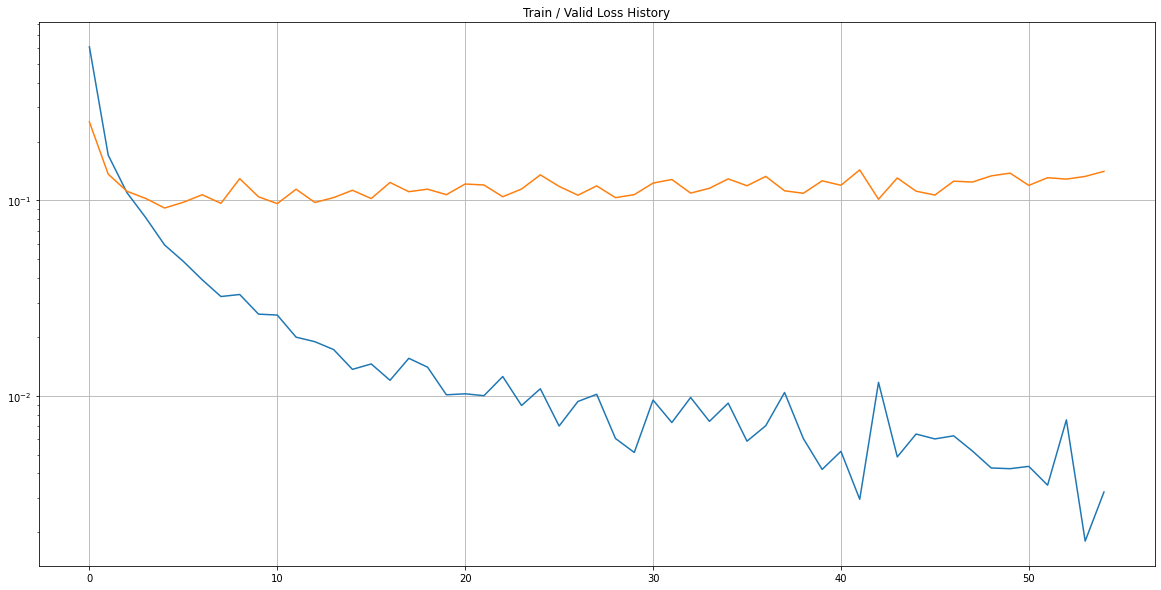

Test loss : 8.4001e-02
Test Accuracy: 0.9754


In [4]:
#T는 컬럼백터를 로우백터로 바꾼것.

#likelihood : 가능도.
# 음의 가능도란?

# 소프트맥스 -> CE
# 로그소프트맥스 -> NLL




import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms


#데이터셋 불러오기

train = datasets.MNIST(
    '../data', train=True, download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)
test = datasets.MNIST(
    '../data', train=False,
    transform=transforms.Compose([transforms.ToTensor()])
)


#이미지 시각화

# x는 벡터다.
# detach는 파이토치의 미분연쇄법칙에서 데이터를 때어내고 더이상 연쇄법칙에 구애받지 않는 상태로 만드는것.
def plot(x) :
    img = (np.array(x.detach().cpu(), dtype='float')).reshape(28,28)

    plt.imshow(img, cmap='gray')
    plt.show()

plot(train.data[0])

# 학습데이터 벡터로 변환

x = train.data.float() / 255. 
y = train.targets

x = x.view(x.size(0), -1)
print(x.shape, y.shape)


# 입출력 데이터 크기 설정
input_size = x.size(-1)
output_size = int(max(y))+1 # y는 0부터 9까지의 숫자니까 9+1=10

print('input_size : %d, output_size : %d' % (input_size, output_size))


# 학습/검증 데이터 분리

# Train / Valid ratio
ratios = [.8, .2]

train_cnt = int(x.size(0)*ratios[0])
valid_cnt = int(x.size(0)*ratios[1])
test_cnt = len(test.data)
cnts = [train_cnt, valid_cnt]

print("Train %d / Valid %d / Test %d samples." % (train_cnt, valid_cnt, test_cnt))

indices = torch.randperm(x.size(0))

x = torch.index_select(x, dim=0, index=indices)
y = torch.index_select(y, dim=0, index=indices)

x = list(x.split(cnts, dim=0))
y = list(y.split(cnts, dim=0))

x += [(test.data.float() / 255.).view(test_cnt, -1)]
y += [test.targets]

for x_i, y_i in zip(x, y) :
    print(x_i.size(), y_i.size())



# 심층신경망 구성

# 문제1은 여기를 건드려서 해결해보라는 것.

model = nn.Sequential(
    nn.Linear(input_size, 500),
    nn.LeakyReLU(),
    nn.Linear(500, 400),
    nn.LeakyReLU(),
    nn.Linear(400, 300),
    nn.LeakyReLU(),
    nn.Linear(300, 200),
    nn.LeakyReLU(),
    nn.Linear(200, 100),
    nn.LeakyReLU(),
    nn.Linear(100, 50),
    nn.LeakyReLU(),
    nn.Linear(50, output_size),
    nn.LogSoftmax(dim=-1),
)


# 옵티마이저 및 손실함수 설정

optimizer = optim.Adam(model.parameters())
crit = nn.NLLLoss()

# GPU 활용 가능 여부 판정

device = torch.device('cpu')
if torch.cuda.is_available() :
    device = torch.device('cuda')

# 모델과 텐서를 선택된 장치로 각각 이동 및 복사.

mode = model.to(device)

x = [x_i.to(device) for x_i in x]
y = [y_i.to(device) for y_i in y]

n_epochs = 1000
batch_size = 256
print_interval = 10

lowest_loss = np.inf
best_model = None

early_stop = 50
lowest_epoch = np.inf


# 학습시작

train_history, valid_history = [], []

for i in range(n_epochs) :
    indices = torch.randperm(x[0].size(0)).to(device)
    x_ = torch.index_select(x[0], dim=0, index=indices)
    y_ = torch.index_select(y[0], dim=0, index=indices)
    
    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)
    train_loss, valid_loss = 0,0
    y_hat = []

    for x_i, y_i in zip(x_, y_) :
        y_hat_i = model(x_i)
        loss = crit(y_hat_i, y_i.squeeze())
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        train_loss += float(loss)

    train_loss = train_loss / len(x_)

    # 학습시작 (검증)
    with torch.no_grad() :
        x_ = x[1].split(batch_size, dim=0)
        y_ = y[1].split(batch_size, dim=0)

        valid_loss = 0
        
        for x_i, y_i in zip(x_, y_) :
            y_hat_i = model(x_i)
            loss = crit(y_hat_i, y_i.squeeze())
        
            valid_loss += float(loss)
            
            y_hat += [y_hat_i]
    
    valid_loss = valid_loss / len(x_)
    
    train_history += [train_loss]
    valid_history += [valid_loss]

    if (i + 1) % print_interval == 0 :
        print('Epoch %d : train loss = %.4e valid_loss=%.4e lowest_loss = %.4e' % (
            i+1, train_loss, valid_loss, lowest_loss
        ))

    # 학습시작(검증) : 조기종료 및 베스트 모델 선택
    if valid_loss <= lowest_loss :
        lowest_loss = valid_loss
        lowest_epoch = i

        best_model = deepcopy(model.state_dict())

    else :
        if early_stop > 0 and lowest_epoch + early_stop < i+1 :
            print("There is no improvement during last %d epochs." % early_stop)
            break

print("The best validation loss from epoch %d : %.4e" % (lowest_epoch+1, lowest_loss))
model.load_state_dict(best_model)


# 손실곡선 확인
plot_from = 0

plt.figure(figsize=(20,10))
plt.grid(True)
plt.title("Train / Valid Loss History")
plt.plot(
    range(plot_from, len(train_history)), train_history[plot_from:],
    range(plot_from, len(valid_history)), valid_history[plot_from:],
)
plt.yscale('log')
plt.show()


# 평가(테스트)

test_loss = 0
y_hat = []

with torch.no_grad() :
    x_ = x[-1].split(batch_size, dim=0)
    y_ = y[-1].split(batch_size, dim=0)

    for x_i, y_i in zip(x_, y_) :
        y_hat_i = model(x_i)
        loss = crit(y_hat_i, y_i.squeeze())
        
        test_loss += loss
        
        y_hat += [y_hat_i]

test_loss = test_loss / len(x_)
y_hat = torch.cat(y_hat, dim=0)

print("Test loss : %.4e" % test_loss)


# 분류 정확도 계산

correct_cnt = (y[-1].squeeze() == torch.argmax(y_hat, dim=-1)).sum()
total_cnt = float(y[-1].size(0))

print("Test Accuracy: %.4f" % (correct_cnt / total_cnt))

# print(y_hat.device)
# print(y)





In [7]:

# 혼동 행렬 출력
import pandas as pd
from sklearn.metrics import confusion_matrix

# y_hat = y_hat.cpu()
# y = [i.cpu().numpy() for i in y]

pd.DataFrame(confusion_matrix(y[-1], torch.argmax(y_hat, dim=-1)),
             index=['true_%d' % i for i in range(10)],
             columns=['pred_%d' % i for i in range(10)])




 

# One-Hot encoding

# 파이토치에서는 원핫인코딩을 해줄 필요가 없다. -> 파이토치가 알아서 해준다.
# y_i.squeeze()는 스칼라라서 벡터와 비교하기가 어려운데 파이토치가 원핫인코딩을 해준다는 뜻.

,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9
true_0,971,0,2,0,0,1,2,2,2,0
true_1,0,1128,2,0,0,0,2,0,3,0
true_2,2,4,1007,0,0,0,1,7,11,0
true_3,0,0,6,978,0,1,0,11,6,8
true_4,0,1,2,0,937,0,8,2,4,28
true_5,1,0,0,12,2,861,3,2,8,3
true_6,5,3,2,1,6,5,933,0,3,0
true_7,1,7,5,0,1,0,0,1005,3,6
true_8,1,2,2,2,1,0,2,3,958,3
true_9,3,5,0,2,4,2,0,11,6,976
